In [1]:
from typing import List

import numpy as np
import csv
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib.colors import TABLEAU_COLORS, BASE_COLORS
from scipy.stats import sem
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import interp1d
from itertools import product
from random import shuffle

colors = list(BASE_COLORS.keys()) # + list(TABLEAU_COLORS.keys())
shuffle(colors)
print(colors)

['r', 'c', 'g', 'w', 'y', 'm', 'b', 'k']


In [2]:
# noise_ws = [0.0, 0.3, 0.75, 1.0]
noise_ws = [0.13496615825145525]
# reward_ws = [0.0, 0.3, 0.6, 1.0]
reward_ws = [0.8546471786192158]
seeds = [12, 42, 69, 10420]
# seeds = [128, 4242, 1234, 48]
# seeds = [12, 42, 69, 10420, 128, 4242, 1234, 48]
# postfix = '_arch'
postfix = ''
# experiment = 'poster_mal_agent_reward'
# experiment = 'report_mal_noise'
experiment = 'report_mal_noise_reward'

In [6]:
def interpolate(x, y, at):
    return interp1d(x, y, kind="linear", fill_value=(np.min(y), np.max(y)), bounds_error=False)(at)

def plot(all_evals: List, label: str, smooth_factor=2, color="b", linestyle=None, max_samples=None, eval_rate=None):
    intervals = np.arange(0, max_samples, eval_rate)
    all_evals = np.stack([interpolate(np.array(evals)[:,0],np.array(evals)[:,1],intervals) for evals in all_evals])
    mean_reward = all_evals.mean(axis=0)
    sem_reward = sem(all_evals, axis=0)
    ci_95 = 1.96 * sem_reward

    mean_reward_smooth = gaussian_filter1d(mean_reward, smooth_factor)
    ci_95_smooth = gaussian_filter1d(ci_95, smooth_factor)

    plt.plot(intervals, mean_reward_smooth, label=label, color=color, linestyle=linestyle)
    plt.fill_between(intervals, mean_reward_smooth - ci_95_smooth, mean_reward_smooth + ci_95_smooth, color=color, alpha=0.2)

def load_evals(path):
    path = Path(path)
    assert path.exists()
    with open(path, newline='') as file:
        rd = csv.reader(file)
        return np.array(list(rd), dtype='float')

[PosixPath('/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/report_mal_noise_reward/sample_efficiency/noise_0.037454020658606035_reward_0.32821411342506474_seed_12'), PosixPath('/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/report_mal_noise_reward/sample_efficiency/noise_0.037454020658606035_reward_0.32821411342506474_seed_42'), PosixPath('/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/report_mal_noise_reward/sample_efficiency/noise_0.037454020658606035_reward_0.32821411342506474_seed_69'), PosixPath('/Users/kacper/Documents/dev/stackelberg-ml/stackelberg_mbrl/experiments/report_mal_noise_reward/sample_efficiency/noise_0.037454020658606035_reward_0.32821411342506474_seed_10420')]


/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3517: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  if await self.run_code(code, result, async_=asy):


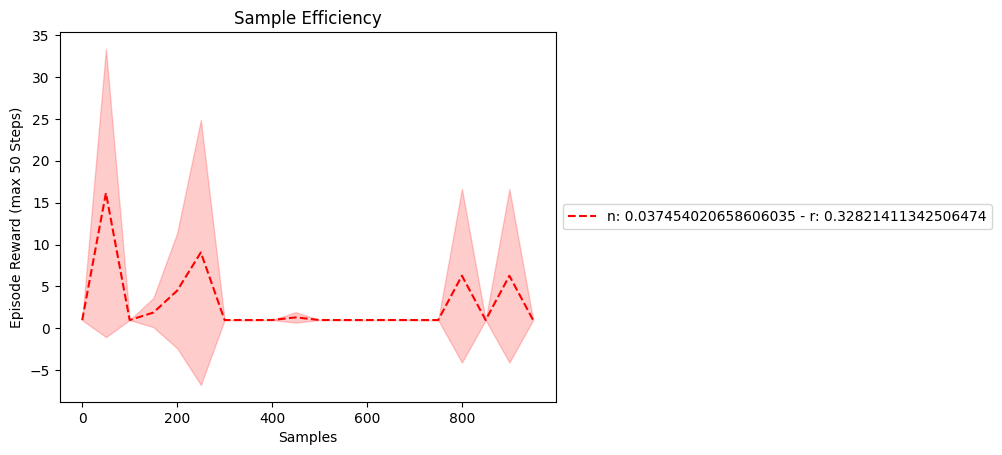

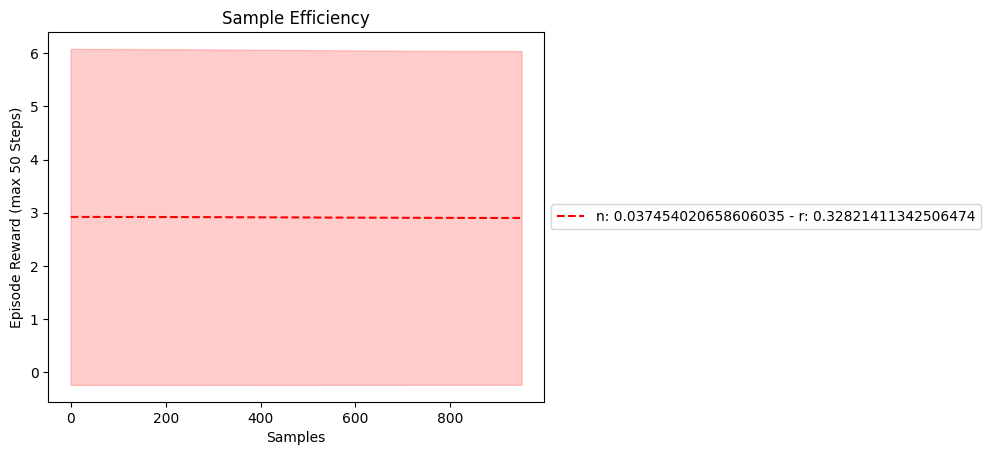

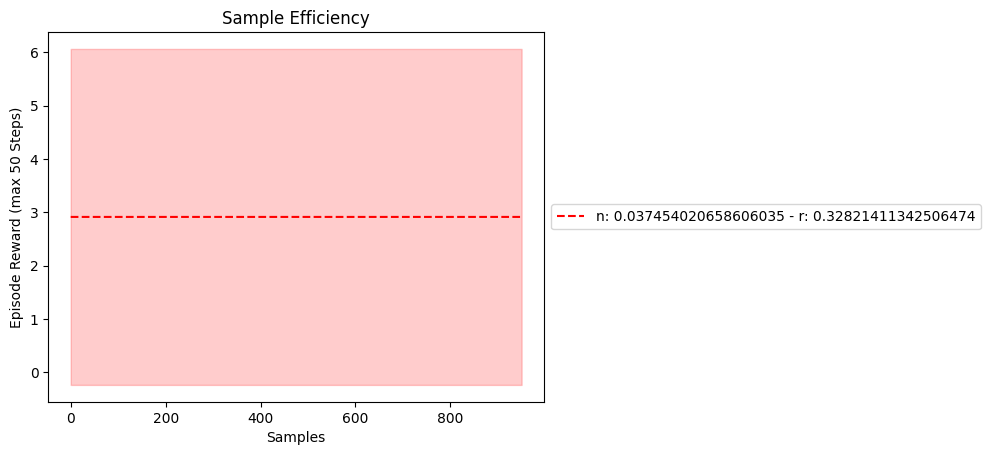

In [7]:
path = Path.cwd()
path = path / "stackelberg_mbrl" / "experiments" / experiment / "sample_efficiency"
stems = list(product(noise_ws, reward_ws))
paths = [path / f"noise_{noise}_reward_{reward}_seed_{seed}{postfix}" for (noise, reward), seed in product(stems, seeds)]
print(paths)
evals = np.stack(load_evals(p) for p in paths)
max_samples = np.max(evals[:, :, 0])
pts_cnt = evals.shape[1]
evals = evals.reshape(-1, len(seeds), pts_cnt, 2)

# plt.style.use('dark_background')
plt.style.use('default')
for smooth_factor in [0.1, 20, 40]:
    plt.figure()
    # smooth_factor = 20.0
    for e, (noise, reward), (c, s) in zip(evals, stems, product(['r', 'g', 'b', 'c', 'y'], ['--','-','-.',':'])):
        plot(e, f"n: {noise} - r: {reward}", smooth_factor=smooth_factor, max_samples=max_samples, eval_rate=50, color=c, linestyle=s)
        
    plt.title("Sample Efficiency")
    plt.ylabel("Episode Reward (max 50 Steps)")
    plt.xlabel("Samples")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# This part is just for creating data

In [4]:
%load_ext autoreload
%autoreload 2

from stackelberg_mbrl.experiments.experiment_config import ExperimentConfig, EnvConfig, PolicyConfig, WorldModelConfig, LoadPolicy, LeaderEnvConfig, SampleEfficiency
from stackelberg_mbrl.train_mal import train_contextualized_MAL
from itertools import product

for reward_w, noise_w, seed in product(reward_ws, noise_ws, seeds):
    config = ExperimentConfig(
        experiment_name=experiment,
        env_config=EnvConfig(
            env_true_id="simple_mdp_2",
            env_eval_id="simple_mdp_2",
            max_episode_steps=50
        ),
        policy_config=LoadPolicy(
            # just use the same one...
            path="stackelberg_mbrl/experiments/poster_mal_agent_reward/checkpoints/policy_simple_mdp_2.zip",
        ),
        # policy_config=PolicyConfig(
        #     pretrain_iterations=1,
        #     samples_per_training_iteration=1_000_000,
        #     model_save_name="policy_simple_mdp_2",
        # ),
        leader_env_config=LeaderEnvConfig(
            env_noise_weight=lambda step: noise_w,
            env_reward_weight=reward_w,
            learning_rate=0.13642027541738172,
        ),
        sample_efficiency=SampleEfficiency(
            sample_eval_rate=20,
            n_eval_episodes=30,
            max_samples=1000,
            log_save_name=f"noise_{noise_w}_reward_{reward_w}_seed_{seed}{postfix}"
        ),
        world_model_config=WorldModelConfig(
            total_training_steps=250_000,
            # total_training_steps=1_000,
            # model_save_name="simple_mdp_2",
        ),
        seed=seed
    )

    train_contextualized_MAL(config)

/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/pydantic/_internal/_fields.py:160: UserWarning: Field "model_save_name" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


experiment_name='report_mal_noise_reward' env_config=EnvConfig(env_true_id='simple_mdp_2', env_eval_id='simple_mdp_2', max_episode_steps=50) policy_config=LoadPolicy(path=PosixPath('stackelberg_mbrl/experiments/poster_mal_agent_reward/checkpoints/policy_simple_mdp_2.zip')) leader_env_config=LeaderEnvConfig(learning_rate=0.7734398798253341, env_reward_weight=0.32821411342506474, env_noise_weight=<function <lambda> at 0x31eaebd00>) world_model_config=WorldModelConfig(total_training_steps=250000, model_save_name=None) sample_efficiency=SampleEfficiency(sample_eval_rate=20, n_eval_episodes=30, max_samples=1000, log_save_name='noise_0.037454020658606035_reward_0.32821411342506474_seed_12') output_dir=PosixPath('stackelberg_mbrl/experiments') seed=12


/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_states` for environment variables or `env.get_wrapper_attr('num_states')` that will search the reminding wrappers.
  logger.warn(
/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_actions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_actions` for environment variables or `env.get_wrapper_attr('num_actions')` that will search the reminding wrappers.
  logger.warn(
/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.draw_mdp to get variables from other wrappers is deprecated and will be removed in v1.0, to get this v

Loading policy model from file.
learning_rate=0.7734398798253341 env_reward_weight=0.32821411342506474 env_noise_weight=<function <lambda> at 0x31eaebd00>


/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/stable_baselines3/ppo/ppo.py:155: UserWarning: You have specified a mini-batch size of 64, but because the `RolloutBuffer` is of size `n_steps * n_envs = 20`, after every 0 untruncated mini-batches, there will be a truncated mini-batch of size 20
We recommend using a `batch_size` that is a factor of `n_steps * n_envs`.
Info: (n_steps=20 and n_envs=1)
  warnings.warn(
/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_states` for environment variables or `env.get_wrapper_attr('num_states')` that will search the reminding wrappers.
  logger.warn(
/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_actions to get variables from other wrappers is d

Output()

/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:181: 
DeprecationWarning: WARN: Current gymnasium version requires that `Env.reset` can be passed `options` to allow the 
environment initialisation to be passed additional information.
  logger.deprecation(

/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: 
env.max_ep_steps to get variables from other wrappers is deprecated and will be removed in v1.0, to get this 
variable you can do `env.unwrapped.max_ep_steps` for environment variables or 
`env.get_wrapper_attr('max_ep_steps')` that will search the reminding wrappers.
  logger.warn(

/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: 
env.initial_state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this 
variable you can do `env.unwrapped.initial_state` for environment variables or 
`env.get_wrapper_attr('initial_state')` that will search the reminding wrappers.
  logger.warn(

/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: 
env.final_state to get variables from other wrappers is deprecated and will be removed in v1.0, to get this 
variable you can do `env.unwrapped.final_state` for environment variables or `env.get_wrapper_attr('final_state')` 
that will search the reminding wrappers.
  logger.warn(

/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: 
UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting 
modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first
with ``Monitor`` wrapper.
  warnings.warn(

Training world model


Model reward: (-0.33333333730697634, 0.5163977871892489)
Avg Policy Reward on learned model:   1.000 ± 0.000
Avg Policy Reward on real env:   0.960 ± 0.049
experiment_name='report_mal_noise_reward' env_config=EnvConfig(env_true_id='simple_mdp_2', env_eval_id='simple_mdp_2', max_episode_steps=50) policy_config=LoadPolicy(path=PosixPath('stackelberg_mbrl/experiments/poster_mal_agent_reward/checkpoints/policy_simple_mdp_2.zip')) leader_env_config=LeaderEnvConfig(learning_rate=0.7734398798253341, env_reward_weight=0.32821411342506474, env_noise_weight=<function <lambda> at 0x32ff43f40>) world_model_config=WorldModelConfig(total_training_steps=250000, model_save_name=None) sample_efficiency=SampleEfficiency(sample_eval_rate=20, n_eval_episodes=30, max_samples=1000, log_save_name='noise_0.037454020658606035_reward_0.32821411342506474_seed_42') output_dir=PosixPath('stackelberg_mbrl/experiments') seed=42


/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.draw_mdp to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.draw_mdp` for environment variables or `env.get_wrapper_attr('draw_mdp')` that will search the reminding wrappers.
  logger.warn(


Loading policy model from file.
learning_rate=0.7734398798253341 env_reward_weight=0.32821411342506474 env_noise_weight=<function <lambda> at 0x32ff43f40>


Output()

Training world model


Model reward: (-1.6666666686534881, 0.5163977756468591)
Avg Policy Reward on learned model:   -2.500 ± 0.000
Avg Policy Reward on real env:   0.995 ± 0.015
experiment_name='report_mal_noise_reward' env_config=EnvConfig(env_true_id='simple_mdp_2', env_eval_id='simple_mdp_2', max_episode_steps=50) policy_config=LoadPolicy(path=PosixPath('stackelberg_mbrl/experiments/poster_mal_agent_reward/checkpoints/policy_simple_mdp_2.zip')) leader_env_config=LeaderEnvConfig(learning_rate=0.7734398798253341, env_reward_weight=0.32821411342506474, env_noise_weight=<function <lambda> at 0x32ffc8ee0>) world_model_config=WorldModelConfig(total_training_steps=250000, model_save_name=None) sample_efficiency=SampleEfficiency(sample_eval_rate=20, n_eval_episodes=30, max_samples=1000, log_save_name='noise_0.037454020658606035_reward_0.32821411342506474_seed_69') output_dir=PosixPath('stackelberg_mbrl/experiments') seed=69
Loading policy model from file.
learning_rate=0.7734398798253341 env_reward_weight=0.3282

Output()

Training world model


Model reward: (-1.999574613571167, 7.734298706054688e-05)
Avg Policy Reward on learned model:   49.000 ± 0.000
Avg Policy Reward on real env:   1.000 ± 0.000
experiment_name='report_mal_noise_reward' env_config=EnvConfig(env_true_id='simple_mdp_2', env_eval_id='simple_mdp_2', max_episode_steps=50) policy_config=LoadPolicy(path=PosixPath('stackelberg_mbrl/experiments/poster_mal_agent_reward/checkpoints/policy_simple_mdp_2.zip')) leader_env_config=LeaderEnvConfig(learning_rate=0.7734398798253341, env_reward_weight=0.32821411342506474, env_noise_weight=<function <lambda> at 0x32ff43be0>) world_model_config=WorldModelConfig(total_training_steps=250000, model_save_name=None) sample_efficiency=SampleEfficiency(sample_eval_rate=20, n_eval_episodes=30, max_samples=1000, log_save_name='noise_0.037454020658606035_reward_0.32821411342506474_seed_10420') output_dir=PosixPath('stackelberg_mbrl/experiments') seed=10420
Loading policy model from file.
learning_rate=0.7734398798253341 env_reward_weigh

Output()

Training world model


Model reward: (-2.0, 0.0)
Avg Policy Reward on learned model:   37.360 ± 4.545
Avg Policy Reward on real env:   36.930 ± 0.531


# Optuna hyperparameter tuning...

### results

{'learning_rate': 0.13642027541738172, 'env_reward_weight': 0.8546471786192158, 'env_noise_weight': 0.13496615825145525}

In [9]:
import stackelberg_mbrl.envs.simple_mdp
import gymnasium
import optuna
import numpy as np
from itertools import product
from stable_baselines3.ppo import PPO
import torch

from stackelberg_mbrl.experiments.experiment_config import ExperimentConfig, EnvConfig, PolicyConfig, WorldModelConfig, LoadPolicy, LeaderEnvConfig, SampleEfficiency
from stackelberg_mbrl.envs.env_util import LearnableWorldModel, RandomMDP
from stackelberg_mbrl.envs.querying_env import ConstantContextEnv, CountedEnvWrapper, LeaderEnv, ModelQueryingEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy

config = ExperimentConfig(
        experiment_name='optuna_mal',
        env_config=EnvConfig(
            env_true_id="simple_mdp_2",
            env_eval_id="simple_mdp_2",
            max_episode_steps=50
        ),
        policy_config=LoadPolicy(
            path="stackelberg_mbrl/experiments/poster_mal_agent_reward/checkpoints/policy_simple_mdp_2.zip",
        ),
        leader_env_config=LeaderEnvConfig(),
        sample_efficiency=SampleEfficiency(
            sample_eval_rate=20,
            n_eval_episodes=10,
            max_samples=350,
            log_save_name="optuna_mal",
        ),
        world_model_config=WorldModelConfig(
            total_training_steps=250_000,
        ),
        seed=42
    )

mean_over = config.sample_efficiency.max_samples // config.sample_efficiency.sample_eval_rate
env_true = gymnasium.make(config.env_config.env_true_id, max_ep_steps=config.env_config.max_episode_steps)
queries = list(product(range(env_true.num_states), range(env_true.num_actions)))
random_mdp = RandomMDP(
        num_states=env_true.num_states,
        num_actions=env_true.num_actions,
        rewards=env_true.rewards,
        initial_state=env_true.initial_state,
        final_state=env_true.final_state,
        max_ep_steps=env_true.max_ep_steps,
    )
querying_random_mdp = ModelQueryingEnv(random_mdp, queries)
policy_ppo = PPO.load(config.policy_config.path, querying_random_mdp)

env_true_count = CountedEnvWrapper(env_true)

class CountedPPOCallback(BaseCallback):
    def __init__(self, model):
        super().__init__(verbose=0)
        self.model = model
        self.next_eval = 0
        self.evals = []
    def _on_training_start(self) -> None: pass
    def _on_rollout_start(self) -> None: pass
    def _on_training_end(self) -> None: pass
    def _on_step(self) -> bool: return config.sample_efficiency.max_samples is None or self.samples < config.sample_efficiency.max_samples
    @property
    def samples(self) -> int: return env_true_count.samples
    def _on_rollout_end(self) -> None:
        if self.samples >= self.next_eval:
            with torch.no_grad():
                learned_world_model = LearnableWorldModel(
                    self.model.policy,
                    env_true.num_states,
                    env_true.num_actions,
                    env_true.max_ep_steps,
                    env_true.rewards,
                    env_true.initial_state,
                    env_true.final_state,
                    )
                model_query_answers = np.concatenate([learned_world_model.next_state_distribution(state, action) for (state, action) in queries])
                real_eval_env = ConstantContextEnv(env_true, model_query_answers)
                
                r_mean,r_std = evaluate_policy(policy_ppo.policy, real_eval_env, n_eval_episodes=config.sample_efficiency.n_eval_episodes)
                self.evals.append((self.samples, r_mean))
                self.next_eval += config.sample_efficiency.sample_eval_rate


def objective(trial: optuna.Trial):

    ## PPO
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1)
    # batch_size = trial.suggest_int('batch_size', 2, 100)
    # use_sde = trial.suggest_categorical('use_sde', [True, False])
    # ent_coef = trial.suggest_float('ent_coef', 0.0, 1.0)
    # vf_coef = trial.suggest_float('vf_coef', 0.0, 1.0)
    env_reward_weight = trial.suggest_float('env_reward_weight', 0.0, 1.0)
    env_noise_weight = trial.suggest_float('env_noise_weight', 0.0, 1.0)

    mean_rewards = []
    last_rewards = []

    for seed in [42, 69, 10420, 128, 4242, 1234, 7]:
        np.random.seed(seed)
        torch.random.manual_seed(seed)

        # env_true = gymnasium.make(config.env_config.env_true_id, max_ep_steps=config.env_config.max_episode_steps)
        # env_true_count = CountedEnvWrapper(env_true)

        env_true_count.samples = 0
        env_true_count.trajectories = 0

        leader_env = LeaderEnv(env_true_count, policy_ppo.policy, queries, env_reward_weight, lambda step: env_noise_weight)

        ## train
        model_ppo = PPO(
            "MlpPolicy",
            leader_env,
            # tensorboard_log=config.output_dir / config.experiment_name / "tb",
            gamma=1.0,
            n_steps=config.sample_efficiency.sample_eval_rate if config.sample_efficiency else 2048,

            learning_rate=learning_rate,
            # batch_size=batch_size,
            # use_sde=use_sde,
            # ent_coef=ent_coef,
            # vf_coef=vf_coef,
        )
        callback = CountedPPOCallback(model=model_ppo)
        model_ppo.learn(
            total_timesteps=config.world_model_config.total_training_steps, 
            # progress_bar=True, 
            # tb_log_name="WorldModel", 
            callback=callback)
        assert len(callback.evals) >= mean_over
        mean_reward = np.mean([x[1] for x in callback.evals[:mean_over]])

        learned_world_model = LearnableWorldModel(
                model_ppo.policy,
                env_true.num_states,
                env_true.num_actions,
                env_true.max_ep_steps,
                env_true.rewards,
                env_true.initial_state,
                env_true.final_state,
                )
        model_query_answers = np.concatenate([learned_world_model.next_state_distribution(state, action) for (state, action) in queries])
        real_eval_env = ConstantContextEnv(env_true, model_query_answers)
        last_reward,_ = evaluate_policy(policy_ppo.policy, real_eval_env, n_eval_episodes=config.sample_efficiency.n_eval_episodes)

        mean_rewards.append(mean_reward)
        last_rewards.append(last_reward)

    # print(last_reward, mean_reward)
    # return mean_reward + 10 * last_reward
    print("mean reward", np.mean(last_rewards))
    return np.mean(mean_rewards) + 10 * np.mean(last_rewards)

###### 

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Print the best set of hyperparameters
print('Best hyperparameters: ', study.best_params)
# Print the corresponding performance
print('Best performance: ', study.best_value)

/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_states to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_states` for environment variables or `env.get_wrapper_attr('num_states')` that will search the reminding wrappers.
  logger.warn(
/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.num_actions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.num_actions` for environment variables or `env.get_wrapper_attr('num_actions')` that will search the reminding wrappers.
  logger.warn(
/Users/kacper/micromamba/envs/stackelberg/lib/python3.10/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.rewards to get variables from other wrappers is deprecated and will be removed in v1.0, to get this va

Best hyperparameters:  {'learning_rate': 0.13642027541738172, 'env_reward_weight': 0.8546471786192158, 'env_noise_weight': 0.13496615825145525}
Best performance:  283.94024999311193
